## **Image Captioning** : 

#### Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions. The dataset is in the form [image → captions]. The dataset consists of input images and their corresponding output captions.


## **Encoder**

#### The Convolutional Neural Network(CNN) can be thought of as an encoder. The input image is given to CNN to extract the features. The last hidden state of the CNN is connected to the Decoder.


## **Decoder**

#### The Decoder is a Recurrent Neural Network(RNN) which does language modelling up to the word level. The first time step receives the encoded output from the encoder and also the start vector.


## **CNN**

#### CNN is a subfield of Deep learning and specialized deep neural networks used for the recognition and classification of images. It is used to process the data represented as a 2D matrix like images. It can deal with scaled, translated, and rotated imagery. It analyzes the visual imagery by scanning them from left to right and top to bottom and extracting relevant features from that. Finally, it combines all the features for image classification.

## **LSTM**

#### Being a type of RNN (recurrent neural network), LSTM (Long short-term memory) is capable of working with sequence prediction problems. It is mostly used for the next word prediction purposes, as in Google search our system is showing the next word based on the previous text. Throughout the processing of inputs, LSTM is used to carry out the relevant information and to discard non-relevant information.

To build an image caption generator model we have to merge CNN with LSTM. We can drive that:

Image Caption Generator Model(CNN-RNN model) = CNN + LSTM.

CNN- To extract features from the image. A pre-trained model called Xception is used for this.

LSTM- To generate a description from the extracted information of the image.

## **GRU**

#### A gated recurrent unit (GRU) is a gating mechanism in recurrent neural networks (RNN) similar to a long short-term memory (LSTM) unit but without an output gate. GRU's try to solve the vanishing gradient problem that can come with standard recurrent neural networks. # Using Gated Recurrent Unit model = tf. keras.

## **Solution Desciption**

We will tackle this problem using an Encoder-Decoder model. Here our encoder model will combine both the encoded form of the image and the encoded form of the text caption and feed to the decoder.

Our model will treat CNN as the ‘image model’ and the RNN/LSTM as the ‘language model’ to encode the text sequences of varying length. The vectors resulting from both the encodings are then merged and processed by a Dense layer to make a final prediction.

We will create a merge architecture in order to keep the image out of the RNN/LSTM and thus be able to train the part of the neural network that handles images and the part that handles language separately, using images and sentences from separate training sets. 

In our merge model, a different representation of the image can be combined with the final RNN state before each prediction.

# **Import Libraries/Dataset**

In [1]:
import pickle
import os
import string
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from keras import Input, layers
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional, add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.utils import pad_sequences, load_img, img_to_array

### Load Pickle file from Drive

In [2]:
infile = open('/kaggle/input/image-captioning-dataset/image-captioning-dataset.pkl','rb')
model = pickle.load(infile)

# **Process Image Name and Caption**

### Data Processing

In [3]:
# get all images with their captions
def img_capt():
   map ={}
   for caption in model[:-1]:
       img, caption = caption.split('\t')
       if ".jpg.1" not in img:
        if img[:-2] not in map:
            map[img[:-2]] = [ caption ]
        else:
            map[img[:-2]].append(caption)
   return map

image_caption_map = img_capt()
print(list(image_caption_map.items())[:4])

[('318667317_108c402140.jpg', ['A man in a black hoodie be hold a paper sign .', 'A homeless man carry a sign that say " hungry " .', 'A bearded man hold a sign .', 'A man in a black hoodie hold a small sign .']), ('2072574835_febf0c5fb9.jpg', ['Three race dog be run out of the start gate on a track .', 'Greyhound dog wear race stripe be run out of a gate on a track .', 'Dog in a race .']), ('3083016677_5782bc337c.jpg', ['Two motorcycle with two rider each .', 'There be two motorcycle with a man and a woman on it .', 'Two guy with helmet be on motorcycle , each with a woman ride behind him', 'Two motorcycle and four rider be on a road .']), ('95734038_2ab5783da7.jpg', ['A man on a bike nest to a river .', 'A man ride a bicycle on a rocky path beside a lake in the mountain .', 'A man stand astride a bike on a rocky trail by a lake .'])]


### Length of the Images

In [4]:
len(image_caption_map)

8036

### Captions cleaned

In [5]:
def clean(mapping):
    table = str.maketrans('', '', string.punctuation)
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.split()
            caption = [word.lower() for word in caption]
            caption = [w.translate(table) for w in caption]
            captions[i] =  ' '.join(caption)

### Captions before processing

In [6]:
# Before Preprocessing

image_caption_map['318667317_108c402140.jpg']

['A man in a black hoodie be hold a paper sign .',
 'A homeless man carry a sign that say " hungry " .',
 'A bearded man hold a sign .',
 'A man in a black hoodie hold a small sign .']

In [7]:
#Cleaning the captions

clean(image_caption_map)

### Captions after processing

In [8]:
#After Cleaning

image_caption_map['318667317_108c402140.jpg']

['a man in a black hoodie be hold a paper sign ',
 'a homeless man carry a sign that say  hungry  ',
 'a bearded man hold a sign ',
 'a man in a black hoodie hold a small sign ']

### Plot Samples with captions

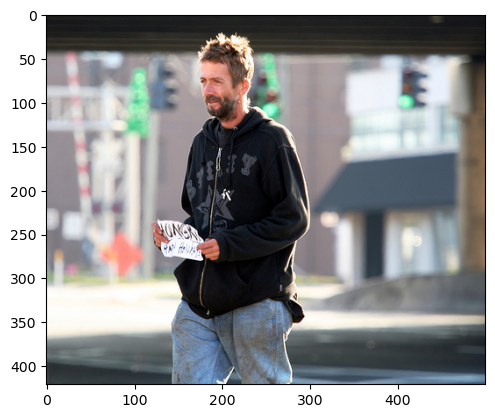

['a man in a black hoodie be hold a paper sign ', 'a homeless man carry a sign that say  hungry  ', 'a bearded man hold a sign ', 'a man in a black hoodie hold a small sign ']


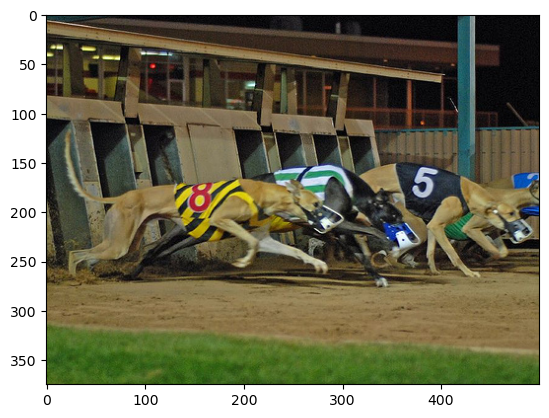

['three race dog be run out of the start gate on a track ', 'greyhound dog wear race stripe be run out of a gate on a track ', 'dog in a race ']


In [9]:
pic = '318667317_108c402140.jpg'
x= plt.imread("/kaggle/input/flickr8k/Images/"+pic)
plt.imshow(x)
plt.show()
print(image_caption_map[pic])

pic = '2072574835_febf0c5fb9.jpg'
x= plt.imread("/kaggle/input/flickr8k/Images/"+pic)
plt.imshow(x)
plt.show()
print(image_caption_map[pic])

### Train and test data modified to required format

In [10]:
vocabulary = set()
for key in image_caption_map.keys():
        [vocabulary.update(d.split()) for d in image_caption_map[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 5539


In [11]:
lines = list()
for key, desc_list in image_caption_map.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [12]:
train = list(image_caption_map.keys())[:len(image_caption_map)]
test = list(image_caption_map.keys())[6001:8030]

In [13]:
img = glob.glob('/kaggle/input/flickr8k/Images/*.jpg')
train_img = []
for i in img: 
    j = i.rsplit('/', 1)[-1]
    if j in train:
        train_img.append(i)

test_img = []
for i in img: 
    j = i.rsplit('/', 1)[-1]
    if j in test: 
        test_img.append(i)

In [14]:
print(len(train_img))

8036


In [15]:
print(len(test_img))

2029


In [16]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [17]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [18]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1240


In [19]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [20]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Train Description Length: %d' % max_length)

Train Description Length: 35


## **Model Building**
### Pretrained Inception Model

### Pretrained Inception model used to train ImageNet dataset (available publicly on google) for image feature extraction.

In [21]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 1s 0us/step


In [22]:
# Model created

model_new = Model(model.input, model.layers[-2].output)

In [23]:
def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [24]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [25]:
images_path = "/kaggle/input/flickr8k/Images/"
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

1/1 [==============================] - 0s 150ms/step


In [26]:
embeddings_index = {} 
f = open('/kaggle/input/glove6b200d/glove.6B.200d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [27]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

 ### Created a 5 layered GRU layer model and other relevant layers for image caption generation

In [28]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(5999,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(5999,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(5999,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(5999,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fifth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

#### Input_1 is the partial caption of max length 34 which is fed into the embedding layer. This is where the words are mapped to the 200-d Glove embedding. It is followed by a dropout of 0.5 to avoid overfitting. This is then fed into the LSTM for processing the sequence.

#### Input_2 is the image vector extracted by our InceptionV3 network. It is followed by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.

#### Both the Image model and the Language model are then concatenated by adding and fed into another Fully Connected layer. The layer is a softmax layer that provides probabilities to our 1660 word vocabulary.

### **L2 regularization added to all the GRU layers.** 

#### **Dropout** - Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass

In [29]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 200)      248200      ['input_3[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

## Model Compilation

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
    metrics=['accuracy'])

## Model Training

In [31]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [32]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

### Model trained for an appropriate number of epochs. The train and validation loss for each epoch is checked.

In [33]:
epochs = 10
batch_size = 3
steps = 1000


generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)

In [34]:
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 273s 267ms/step - loss: 3.8447 - accuracy: 0.2967
Epoch 2/10
1000/1000 [==============================] - 257s 257ms/step - loss: 3.2117 - accuracy: 0.3552
Epoch 3/10
1000/1000 [==============================] - 239s 239ms/step - loss: 3.0455 - accuracy: 0.3712
Epoch 4/10
1000/1000 [==============================] - 267s 267ms/step - loss: 2.8744 - accuracy: 0.3838
Epoch 5/10
1000/1000 [==============================] - 255s 255ms/step - loss: 2.8101 - accuracy: 0.3902
Epoch 6/10
1000/1000 [==============================] - 254s 254ms/step - loss: 2.7467 - accuracy: 0.3967
Epoch 7/10
1000/1000 [==============================] - 267s 266ms/step - loss: 2.6849 - accuracy: 0.4011
Epoch 8/10
1000/1000 [==============================] - 248s 248ms/step - loss: 2.6480 - accuracy: 0.4059
Epoch 9/10
1000/1000 [==============================] - 270s 270ms/step - loss: 2.6137 - accuracy: 0.4091
Epoch 10/10
1000/1000 [=======================

### Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [35]:
print(history.history)

{'loss': [3.844660997390747, 3.2117388248443604, 3.0455145835876465, 2.8744282722473145, 2.810107946395874, 2.746662139892578, 2.6848649978637695, 2.648040533065796, 2.613732099533081, 2.5583927631378174], 'accuracy': [0.29674944281578064, 0.35524946451187134, 0.37122949957847595, 0.3837686777114868, 0.39021071791648865, 0.39667215943336487, 0.40114888548851013, 0.4058825969696045, 0.4090752601623535, 0.41489216685295105]}


### Train Accuracy and Loss

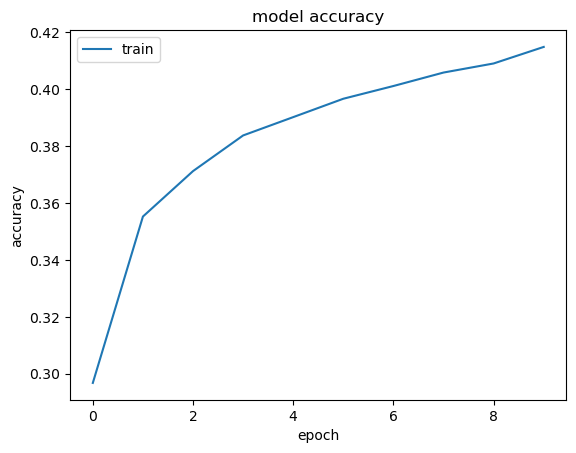

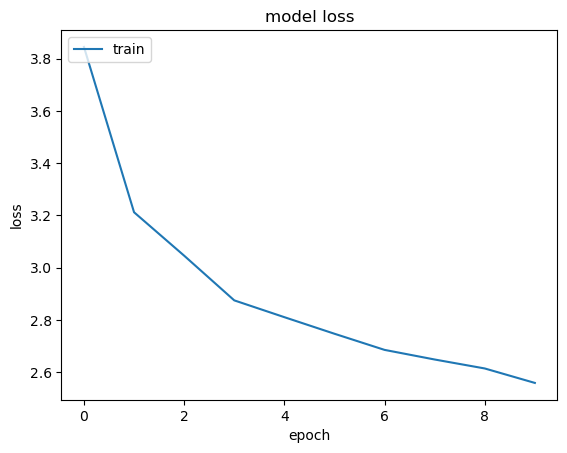

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

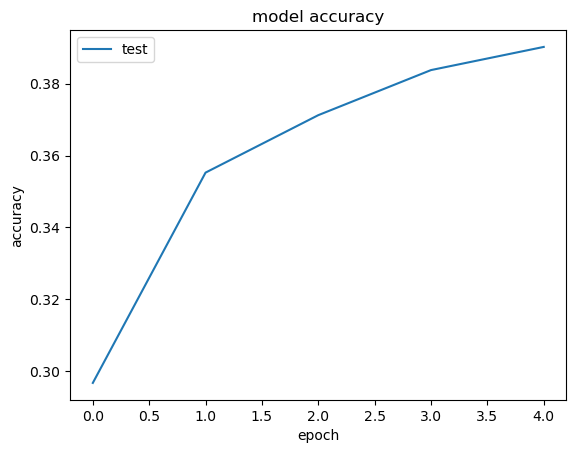

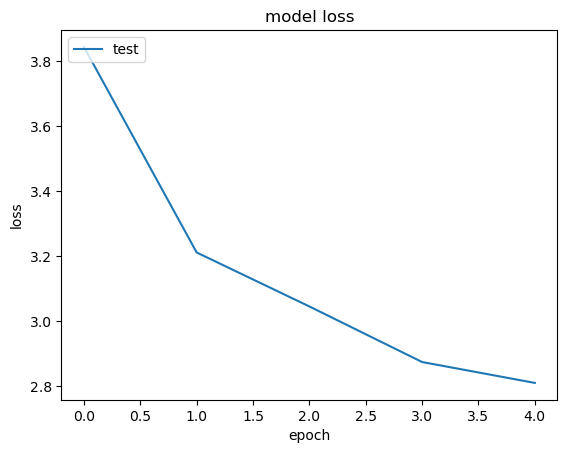

In [37]:
# summarize history for accuracy
plt.plot(history.history['accuracy'][:5])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][:5])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

### Model Evaluation

In [38]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [39]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

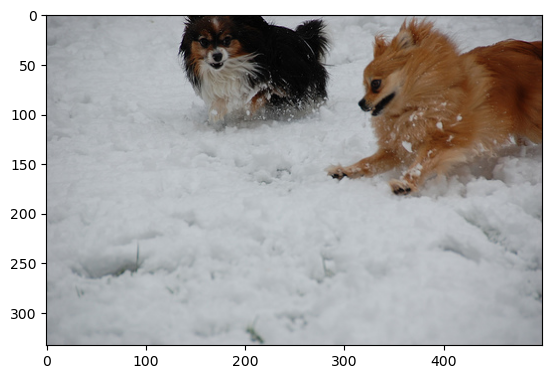

Greedy Search: a dog be play with a ball
Beam Search, K = 3: a black and white dog play with a tennis ball in the snow
Beam Search, K = 5: a black and white dog play with a tennis ball in the snow
Beam Search, K = 7: a brown and white dog play with a tennis ball in the snow
Beam Search, K = 10: a brown and white dog play with a tennis ball in the snow


In [40]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

### A random image from google was taken and caption generated for that image.

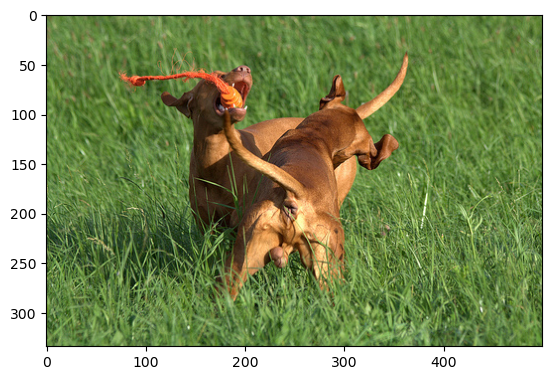

Greedy: a dog run through the grass
Beam Search, K = 3: a brown and white dog run through the grass
Beam Search, K = 5: a brown and white dog run through the grass
Beam Search, K = 7: a brown and white dog play with a tennis ball in a field


In [41]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))